In [1]:
from tracr.rasp import rasp

def make_sort_unique(vals: rasp.SOp, keys: rasp.SOp) -> rasp.SOp:
  """Returns vals sorted by < relation on keys.

  Only supports unique keys.

  Example usage:
    sort = make_sort(rasp.tokens, rasp.tokens)
    sort([2, 4, 3, 1])
    >> [1, 2, 3, 4]

  Args:
    vals: Values to sort.
    keys: Keys for sorting.
  """
  smaller = rasp.Select(keys, keys, rasp.Comparison.LT).named("smaller")
  target_pos = rasp.SelectorWidth(smaller).named("target_pos")
  sel_new = rasp.Select(target_pos, rasp.indices, rasp.Comparison.EQ)
  return rasp.Aggregate(sel_new, vals).named("sort")


def make_sort(vals: rasp.SOp, keys: rasp.SOp, *, max_seq_len: int,
              min_key: float) -> rasp.SOp:
  """Returns vals sorted by < relation on keys, which don't need to be unique.

  The implementation differs from the RASP paper, as it avoids using
  compositions of selectors to break ties. Instead, it uses the arguments
  max_seq_len and min_key to ensure the keys are unique.

  Note that this approach only works for numerical keys.

  Example usage:
    sort = make_sort(rasp.tokens, rasp.tokens, 5, 1)
    sort([2, 4, 3, 1])
    >> [1, 2, 3, 4]
    sort([2, 4, 1, 2])
    >> [1, 2, 2, 4]

  Args:
    vals: Values to sort.
    keys: Keys for sorting.
    max_seq_len: Maximum sequence length (used to ensure keys are unique)
    min_key: Minimum key value (used to ensure keys are unique)

  Returns:
    Output SOp of sort program.
  """
  keys = rasp.SequenceMap(lambda x, i: x + min_key * i / max_seq_len, keys,
                          rasp.indices)
  return make_sort_unique(vals, keys)


In [2]:
from tracr.compiler import compiling

sort = make_sort(rasp.tokens, rasp.tokens, max_seq_len=20, min_key=1)
bos = "BOS"
max_seq_len=5
model = compiling.compile_rasp_to_model(
    sort,
    vocab={10, 20, 30, 40, 50},
    max_seq_len=max_seq_len,
    compiler_bos=bos,
)
print(model.model_config)

TransformerConfig(num_heads=1, num_layers=3, key_size=27, mlp_hidden_size=25, dropout_rate=0.0, activation_function=<jax._src.custom_derivatives.custom_jvp object at 0x76723c6b76e0>, layer_norm=False, causal=False)


In [3]:
from tracr.rasp import rasp

def make_sort_unique_buggy(vals: rasp.SOp, keys: rasp.SOp) -> rasp.SOp:
  """Returns vals sorted by < relation on keys.

  Only supports unique keys.

  Example usage:
    sort = make_sort(rasp.tokens, rasp.tokens)
    sort([2, 4, 3, 1])
    >> [1, 2, 3, 4]

  Args:
    vals: Values to sort.
    keys: Keys for sorting.
  """
  # BUG: GT instead of LT, resulting in descending order instead of ascending
  smaller = rasp.Select(keys, keys, rasp.Comparison.GT).named("smaller")
  target_pos = rasp.SelectorWidth(smaller).named("target_pos")
  sel_new = rasp.Select(target_pos, rasp.indices, rasp.Comparison.EQ)
  return rasp.Aggregate(sel_new, vals).named("sort")


def make_sort_buggy(vals: rasp.SOp, keys: rasp.SOp, *, max_seq_len: int,
              min_key: float) -> rasp.SOp:
  """Returns vals sorted by < relation on keys, which don't need to be unique.

  The implementation differs from the RASP paper, as it avoids using
  compositions of selectors to break ties. Instead, it uses the arguments
  max_seq_len and min_key to ensure the keys are unique.

  Note that this approach only works for numerical keys.

  Example usage:
    sort = make_sort(rasp.tokens, rasp.tokens, 5, 1)
    sort([2, 4, 3, 1])
    >> [1, 2, 3, 4]
    sort([2, 4, 1, 2])
    >> [1, 2, 2, 4]

  Args:
    vals: Values to sort.
    keys: Keys for sorting.
    max_seq_len: Maximum sequence length (used to ensure keys are unique)
    min_key: Minimum key value (used to ensure keys are unique)

  Returns:
    Output SOp of sort program.
  """
  keys = rasp.SequenceMap(lambda x, i: x + min_key * i / max_seq_len, keys,
                          rasp.indices)
  return make_sort_unique_buggy(vals, keys)

In [13]:
from tracr.compiler import compiling

sort = make_sort(rasp.tokens, rasp.tokens, max_seq_len=20, min_key=1)
bos = "BOS"
max_seq_len=5
model = compiling.compile_rasp_to_model(
    sort,
    vocab={10, 20, 30, 40, 50},
    max_seq_len=max_seq_len,
    compiler_bos=bos,
)
print(model.model_config)


buggy_sort = make_sort_buggy(rasp.tokens, rasp.tokens, max_seq_len=20, min_key=1)
bos = "BOS"
max_seq_len=5
buggy_model = compiling.compile_rasp_to_model(
    buggy_sort,
    vocab={10, 20, 30, 40, 50},
    max_seq_len=max_seq_len,
    compiler_bos=bos,
)
print(buggy_model.model_config)

TransformerConfig(num_heads=1, num_layers=3, key_size=27, mlp_hidden_size=25, dropout_rate=0.0, activation_function=<jax._src.custom_derivatives.custom_jvp object at 0x76723c6b76e0>, layer_norm=False, causal=False)
TransformerConfig(num_heads=1, num_layers=3, key_size=27, mlp_hidden_size=25, dropout_rate=0.0, activation_function=<jax._src.custom_derivatives.custom_jvp object at 0x76723c6b76e0>, layer_norm=False, causal=False)


In [14]:
import numpy as np
import jax

acceptedTokens = [10, 20, 30, 40, 50]
maxSeqLength = max_seq_len
size = 1000
X = []
Y = []

for i in range(size):
    # TODO: implement padding for training
    # inputLength = np.random.randint(2, maxSeqLength+1)  #Uniformly distributed between 2 and max length
    inputLength = maxSeqLength

    inputSeq = []
    outputSeq = []
    for t in np.random.choice(acceptedTokens, inputLength):
        inputSeq.append(t)
        outputSeq.append(t)

    inputSeq.insert(0, bos)
    outputSeq.sort()
    outputSeq.insert(0, 10) # The output_encoder does has a None bos_encoding, so we use the input_encoder's

    inputSeq = jax.numpy.array(model.input_encoder.encode(inputSeq))
    outputSeq = jax.numpy.array(model.output_encoder.encode(outputSeq))

    X.append(inputSeq)
    Y.append(outputSeq)

X = jax.numpy.array(X)
Y = jax.numpy.array(Y)

X, Y
print(X.shape)

# Remove duplicates from X, and the corresponding Y
X, indices = np.unique(X, return_index=True, axis=0)
Y = Y[indices]
print(X.shape)

# Split test and validation
split = int(X.shape[0] * 0.90)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]
print(X_train.shape, X_test.shape)

(1000, 6)
(860, 6)
(774, 6) (86, 6)


In [15]:
import haiku as hk
import jax

params = model.params
hk_model = hk.transform(model.get_compiled_model)
hk_model = hk_model.apply(params, jax.random.PRNGKey(42))
hk_model.use_unembed_argmax = False

In [16]:
def forward(x):
    return hk_model(x)

forward = hk.without_apply_rng(hk.transform(forward))

In [17]:
print("Encoding map:")
print(model.input_encoder.encoding_map)

print("Example input and output:")
print(X_train[0])
print(Y_train[0])

print("Example forward pass:")
output = forward.apply(model.params, jax.numpy.array([X_train[0]]))
print(output.unembedded_output)
print(output.unembedded_output.argmax(axis=-1)[0])

print("Example forward pass with model wrapper:")
print(model.apply([bos, 40, 50, 20, 30, 40]).decoded)

Encoding map:
{10: 0, 20: 1, 30: 2, 40: 3, 50: 4, 'BOS': 5, 'compiler_pad': 6}
Example input and output:
[5 0 0 0 0 3]
[0 0 0 0 0 3]
Example forward pass:
[[[2.6479832e-04 0.0000000e+00 0.0000000e+00 6.6199580e-05 0.0000000e+00]
  [9.9993372e-01 0.0000000e+00 0.0000000e+00 4.3849981e-09 0.0000000e+00]
  [9.9993372e-01 0.0000000e+00 0.0000000e+00 4.3849981e-09 0.0000000e+00]
  [9.9993372e-01 0.0000000e+00 0.0000000e+00 4.3849981e-09 0.0000000e+00]
  [9.9993372e-01 0.0000000e+00 0.0000000e+00 4.3849981e-09 0.0000000e+00]
  [1.7539833e-08 0.0000000e+00 0.0000000e+00 9.9993372e-01 0.0000000e+00]]]
[0 0 0 0 0 3]
Example forward pass with model wrapper:
['BOS', 20, 30, 40, 40, 50]


In [18]:
import jax
import optax
import jax.numpy as jnp

from typing import NamedTuple

@jax.jit
def cross_entropy(logits, labels):
  return -jnp.sum(labels * jax.nn.log_softmax(logits)) / logits.shape[0]

# TODO: ignore first position and apply softmax after ignoring first position
@jax.jit
def loss_fn(params, x, y):
  logits = forward.apply(params, x).unembedded_output
  labels = jax.nn.one_hot(y, logits.shape[-1])
  return cross_entropy(logits, labels)

class TrainingState(NamedTuple):
  params: hk.Params
  opt_state: optax.OptState

# FIXME: jax.jit is not working due to some problem with vmap
# @jax.jit
def update(optimiser, state: TrainingState, x, y) -> TrainingState:
  """Learning rule (stochastic gradient descent)."""
  grads = jax.grad(loss_fn)(state.params, x, y)
  updates, opt_state = optimiser.update(grads, state.opt_state)
  params = optax.apply_updates(state.params, updates)
  # TODO: perhaps use incremental updates with average params
  return TrainingState(params, opt_state)

In [19]:
import tqdm
import matplotlib.pyplot as plt

def train(initial_params, X, Y, n_epochs=1, batch_size=8, lr=0.0001, plot=False):
    losses = []  # to store the loss values

    optimiser = optax.adam(lr)
    state = TrainingState(initial_params, optimiser.init(params))

    for _ in tqdm.trange(n_epochs):
        for i in range(0, len(X), batch_size):
            x = X[i:i + batch_size]
            y = Y[i:i + batch_size]
            state = update(optimiser, state, x, y)
            
        # Compute loss every epoch
        if plot:
            loss = loss_fn(state.params, X, Y)
            losses.append(loss)

    if plot:
        # plot the loss values
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()

    return state.params

In [20]:
def evaluate(params, X, Y):
    """
    Computes the accuracy (exact-match) of the model on the given data (X) and labels (Y).
    """
    correct = 0
    for x, y in zip(X, Y):
        logits = forward.apply(params, jax.numpy.array([x])).unembedded_output
        pred = jnp.argmax(logits, axis=-1)[0]
        correct += jnp.all(pred[1:] == y[1:])
    return correct / len(X)

In [22]:
print("Correct model: ", evaluate(model.params, X_test, Y_test))
print("Buggy model: ", evaluate(buggy_model.params, X_test, Y_test))

Correct model:  1.0
Buggy model:  0.0


100%|██████████| 5000/5000 [13:17<00:00,  6.27it/s]


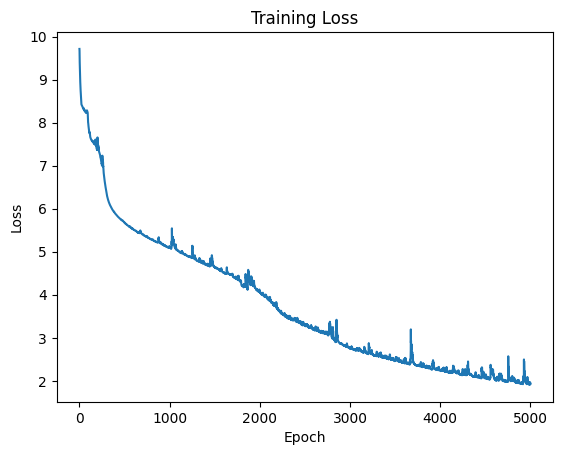

In [23]:
new_params = train(buggy_model.params, X_train, Y_train, n_epochs=5000, batch_size=256, lr=1e-5, plot=True)

In [24]:
print(X_test[0])
print(Y_test[0])

print(forward.apply(new_params, jax.numpy.array([X_test[0]])).unembedded_output.argmax(axis=-1)[0])

[5 4 2 2 4 0]
[0 0 2 2 4 4]
[0 0 2 2 4 4]


In [25]:
evaluate(new_params, X_test, Y_test)

Array(0.29069766, dtype=float32, weak_type=True)

In [26]:
def initialize_normal(params, mean=0.0, std=1.0):
    return jax.tree_util.tree_map(
        lambda p: jax.random.normal(jax.random.PRNGKey(42), p.shape) * std + mean,
        params
    )

random_params = initialize_normal(model.params)

In [27]:
evaluate(random_params, X_test, Y_test)

Array(0., dtype=float32, weak_type=True)

In [28]:
print(X_test[0])
print(Y_test[0])

print(forward.apply(random_params, jax.numpy.array([X_test[0]])).unembedded_output.argmax(axis=-1)[0])

[5 4 2 2 4 0]
[0 0 2 2 4 4]
[1 0 2 1 2 1]


In [33]:
import pandas as pd

# Define the hyper-parameter values to search
n_epochs_values = [100]
batch_size_values = [256]
learning_rate_values = [1e-5]

# Create an empty DataFrame to store the results
results = []

# Perform hyper-parameter search
for n_epochs in n_epochs_values:
    for batch_size in batch_size_values:
        for learning_rate in learning_rate_values:
            # Train the model with the current hyper-parameters
            trained_params = train(random_params, X_train, Y_train, n_epochs=n_epochs, batch_size=batch_size, lr=learning_rate)
            
            # Evaluate the model on the test set
            accuracy = evaluate(trained_params, X_test, Y_test)
            
            # Append the results to the DataFrame
            results.append({"n_epochs": n_epochs, "batch_size": batch_size, "learning_rate": learning_rate, "accuracy": accuracy})

# Print the results
print(pd.DataFrame(results).to_string())

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


   n_epochs  batch_size  learning_rate accuracy
0       100         256        0.00001      0.0


In [34]:
print(X_test[0])
print(Y_test[0])

print(forward.apply(trained_params, jax.numpy.array([X_test[0]])).unembedded_output.argmax(axis=-1)[0])

[5 4 2 2 4 0]
[0 0 2 2 4 4]
[0 0 0 0 0 0]


In [35]:
trained_params

{'pos_embed': {'embeddings': Array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, 